In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [114]:
def fraction(seq):
    n_b = 0.0
    n_bc = 0.0
    n_cb = 0.0
    
    for i in range(0, 32):
        if seq[i] == 1:
            n_b += 1
    
    
    for i in range(1, 32):
        if seq[i-1] + seq[i] == 0:
            if seq[i] == 1:
                n_cb += 1
            else:
                n_bc += 1
    
    n_c = 32.0 - n_b
    p_b = n_b / 32.0
    p_c = n_c / 32.0
    
    p_cb = n_cb / n_b
    p_bb = 1.0 - p_cb
    p_bc = n_bc / n_c
    p_cc = 1.0 - p_bc 
    
    bn = p_bb * p_cc - p_bc * p_cb
    
    return bn

def blockiness(seq):
    """
        seq:    0 0 1 0 1 1
        shift:    0 0 2 0 2 2
        res:      0 1 2 1 3
    """
    seq = (seq + 1)/2
    res = seq[..., 1:] + 2*seq[..., :-1]
    
    nbb = np.count_nonzero(res==0, axis=1)
    nbc = np.count_nonzero(res==1, axis=1)
    ncb = np.count_nonzero(res==2, axis=1)
    ncc = np.count_nonzero(res==3, axis=1)
    nb = np.sum(seq, axis=1)
    nc = 32 - nb
    
    if nb == 0:
        pcb = 0
        pbb = 0
    else:
        pcb = ncb / nb
        pbb = nbb / nb
        
    if nc == 0:
        pbc = 0
        pcc = 0
    else:
        pbc = nbc/nc
        pcc = ncc/nc
    
    BN = pbb*pcc-pbc*pcb
    
    return BN
    

def data_analysis(dataset):
    set = SeqData(dataset=dataset)
    iter = DataLoader(set, batch_size=set.__len__(), shuffle=True)
    # iter = DataLoader(set, 1, shuffle=True)
    for seq, CP, F, BN, label in iter:
        plt.scatter(F, label, marker='.')
        plt.title(dataset+'-F')
        plt.show()
        if dataset == 'D':
            plt.scatter(CP, label, marker='.')
            plt.title(dataset+'-CP')
            plt.show()
        plt.scatter(BN, label, marker='.')
        plt.title(dataset+'-BN')
        plt.show()
    return

def train(dataset, batch_size, lr, epochs):
    set = SeqData(dataset=dataset)
    iter = DataLoader(
        dataset=set,
        batch_size=batch_size,
        shuffle=True,
    )
    Model = SeqModel()
    Loss = nn.MSELoss()
    optimizer = optim.Adam(Model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    curve = list()
    
    # if torch.cuda.is_available():
    #     Model = Model.cuda()
    
    for epoch in range(epochs):
        iter_n, total_loss = 0, 0
        
        for seq, CP, F, BN, label in iter:
            # if torch.cuda.is_available():
            #     cp, seq, label = cp.cuda(), seq.cuda(), label.cuda()
            
            optimizer.zero_grad()
            pred, _ = Model(seq, CP, F, BN)
            loss = Loss(pred, label)
            loss.backward()
            optimizer.step()
            if epoch % 10 == 0:
                print(loss)
            
            total_loss += loss
            iter_n += 1
        
        curve.append(total_loss/iter_n)
        
    # plt.plot(curve)
    # plt.show()

    return Model

def eval(dataset, Model):
    set = SeqData(dataset=dataset)
    iter = DataLoader(
        dataset=set,
        batch_size=set.__len__(),
        shuffle=True,
    )
    Model.eval()
    Loss = nn.MSELoss()
    for seq, CP, F, BN, label in iter:
        pred, SF = Model(seq, CP, F, BN)
        loss = Loss(pred, label)
        # print(loss)
    
    pred, SF = pred.detach(), SF.detach()
    plt.scatter(pred, label, marker='.')
    plt.plot([torch.min(label),torch.max(label)],[torch.min(label),torch.max(label)], color='orange', linewidth=2)
    plt.show()
    print(np.linalg.norm(np.array(pred-label).flatten())/len(label))
    # plt.scatter(SF, label, marker='.')
    # plt.show()
    return 

def trainD(dataset, batch_size, lr, epochs, Model_all):
    set = SeqData(dataset=dataset)
    iter = DataLoader(
        dataset=set,
        batch_size=batch_size,
        shuffle=True,
    )
    FModel = FusionModel(Model_all)
    Loss = nn.MSELoss()
    optimizer = optim.Adam(FModel.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    
    for epoch in range(epochs):
        
        for seq, CP, F, BN, label in iter:
            optimizer.zero_grad()
            pred = FModel(seq, CP)
            loss = Loss(pred, label)
            if epoch % 100 == 0 or epoch % 50 == 10:
                print(loss)
            loss.backward()
            optimizer.step()

    return FModel

def evalD(dataset, FModel):
    set = SeqData(dataset=dataset)
    iter = DataLoader(
        dataset=set,
        batch_size=set.__len__(),
        shuffle=True,
    )
    FModel.eval()
    Loss = nn.MSELoss()
    for seq, CP, F, BN, label in iter:
        pred = FModel(seq, CP)
        loss = Loss(pred, label)
        # print(loss)

    pred = pred.detach()
    plt.scatter(pred, label, marker='.')
    plt.plot([torch.min(label),torch.max(label)],[torch.min(label),torch.max(label)], color='orange', linewidth=2)
    plt.show()
    print(np.linalg.norm(np.array(pred-label).flatten())/len(label))
    print(np.array(pred-label).flatten(), len(label))
    # plt.scatter(SF, label, marker='.')
    # plt.show()
    return

In [10]:
class SeqData(Dataset):
    def __init__(self, root_path='./dataset', dataset='ABCD') -> None:
        super().__init__()
        datasets_path = list(dataset)
        self.datasets = list()
        for subset_path in datasets_path:
            with open(os.path.join(root_path, 'dataset' + subset_path)) as f:
                for data in f.readlines():
                    data = np.array(list(map(float, data.split())))
                    self.datasets.append(data)
        self.datasets = np.array(self.datasets)
        
    def __getitem__(self, index):
        data = self.datasets[index].astype('float32')
        CP, seq, label = data[0].reshape(1), (data[1:-1]*2-1).reshape(1,32), data[-1].reshape(1)
        F = np.mean(seq, axis=1).astype('float32')
        BN = blockiness(seq).astype('float32')
        return seq, CP, F, BN, label

    def __len__(self):
        return np.shape(self.datasets)[0]


In [11]:
class LeNet1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(80, 9)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(9, 1)
        self.relu4 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def SeqForward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        # y = self.sigmoid(y)
        return y
    
class SeqModel(LeNet1d):
    def __init__(self):
        super().__init__()
        self.fc3 = nn.Linear(4, 4)
        self.relu5 = nn.ReLU()
        self.fc4 = nn.Linear(4, 1)
        self.relu6 = nn.ReLU()
    
    def forward(self, seq, CP=None, F=None, BN=None):
        # seq feature
        SF = self.SeqForward(seq)
        # chemical parameter

        # (16,3)
        # x = torch.cat([CP,F,BN], dim=1)
        # change the net 3->4 4->1
        # x = self.fc3(x)
        # x = self.relu5(x)
        # x = self.fc4(x)
        # x = self.relu6(x)
        
        x = SF
        
        return x, SF

class FusionModel(SeqModel):
    def __init__(self, Model_all):
        super().__init__()
        model_all = torch.load(Model_all)
        self.A = SeqModel()
        self.B = SeqModel()
        self.C = SeqModel()
        self.A.load_state_dict(model_all['A'])
        self.B.load_state_dict(model_all['B'])
        self.C.load_state_dict(model_all['C'])
        self.fc1 = nn.Linear(4,3)
        self.relu = nn.ReLU()
    
    def forward(self, seq, CP):
        # IF FROZEN
        # with torch.no_grad():
        A, _ = self.A(seq)
        B, _ = self.B(seq)
        C, _ = self.C(seq)
        Acp = torch.zeros_like(CP)
        Bcp = torch.ones_like(CP)
        Ccp = torch.ones_like(CP)*3.5
        w = torch.cat([Acp,Bcp,Ccp,CP], dim=1)
        w = self.fc1(w)
        w = self.relu(w)
        x = torch.mean(torch.cat([A,B,C], dim=1) * w, dim=1, keepdim=True)

        return x
        

tensor(257.1069, grad_fn=<MseLossBackward0>)
tensor(257.9216, grad_fn=<MseLossBackward0>)
tensor(258.0594, grad_fn=<MseLossBackward0>)
tensor(265.7155, grad_fn=<MseLossBackward0>)
tensor(257.0296, grad_fn=<MseLossBackward0>)
tensor(261.8673, grad_fn=<MseLossBackward0>)
tensor(257.2654, grad_fn=<MseLossBackward0>)
tensor(259.9250, grad_fn=<MseLossBackward0>)
tensor(256.8528, grad_fn=<MseLossBackward0>)
tensor(263.1707, grad_fn=<MseLossBackward0>)
tensor(259.0089, grad_fn=<MseLossBackward0>)
tensor(252.8587, grad_fn=<MseLossBackward0>)
tensor(269.1664, grad_fn=<MseLossBackward0>)
tensor(257.0412, grad_fn=<MseLossBackward0>)
tensor(243.5922, grad_fn=<MseLossBackward0>)
tensor(244.9977, grad_fn=<MseLossBackward0>)
tensor(263.1316, grad_fn=<MseLossBackward0>)
tensor(261.9877, grad_fn=<MseLossBackward0>)
tensor(257.5295, grad_fn=<MseLossBackward0>)
tensor(255.8263, grad_fn=<MseLossBackward0>)
tensor(252.7531, grad_fn=<MseLossBackward0>)
tensor(259.6931, grad_fn=<MseLossBackward0>)
tensor(257

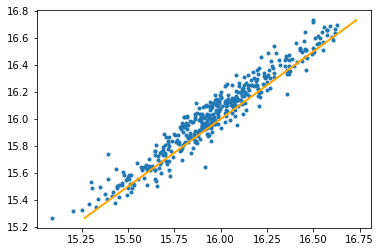

0.004871555896991855


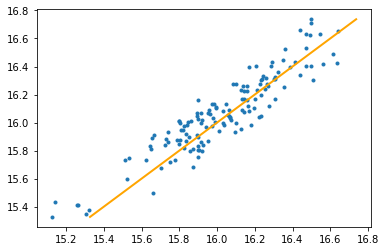

0.010472238063812256


In [60]:
Model_A = train(dataset='A',
                batch_size=2,
                lr=2e-4,
                epochs=128+64)

eval('A', Model_A)
eval('E', Model_A)

tensor(245.9162, grad_fn=<MseLossBackward0>)
tensor(274.0383, grad_fn=<MseLossBackward0>)
tensor(256.9643, grad_fn=<MseLossBackward0>)
tensor(250.7207, grad_fn=<MseLossBackward0>)
tensor(268.7794, grad_fn=<MseLossBackward0>)
tensor(246.4562, grad_fn=<MseLossBackward0>)
tensor(256.7562, grad_fn=<MseLossBackward0>)
tensor(243.6644, grad_fn=<MseLossBackward0>)
tensor(253.0466, grad_fn=<MseLossBackward0>)
tensor(256.0096, grad_fn=<MseLossBackward0>)
tensor(248.1831, grad_fn=<MseLossBackward0>)
tensor(244.7355, grad_fn=<MseLossBackward0>)
tensor(249.0592, grad_fn=<MseLossBackward0>)
tensor(245.8360, grad_fn=<MseLossBackward0>)
tensor(256.3586, grad_fn=<MseLossBackward0>)
tensor(241.3129, grad_fn=<MseLossBackward0>)
tensor(245.9794, grad_fn=<MseLossBackward0>)
tensor(267.8844, grad_fn=<MseLossBackward0>)
tensor(249.9552, grad_fn=<MseLossBackward0>)
tensor(254.7426, grad_fn=<MseLossBackward0>)
tensor(250.1913, grad_fn=<MseLossBackward0>)
tensor(247.5731, grad_fn=<MseLossBackward0>)
tensor(243

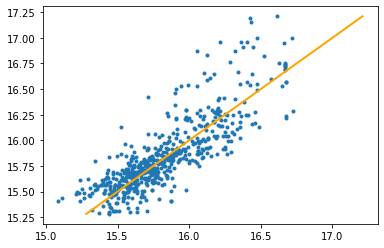

0.008301792873276604


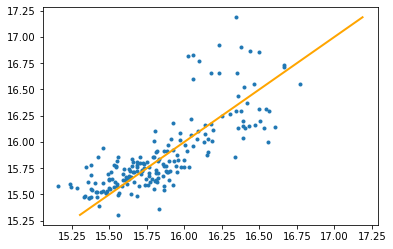

0.01686281089981397


In [63]:
Model_B = train(dataset='B',
                batch_size=2,
                lr=8e-5,
                epochs=512)

eval('B', Model_B)
eval('F', Model_B)

tensor(243.8686, grad_fn=<MseLossBackward0>)
tensor(253.1328, grad_fn=<MseLossBackward0>)
tensor(241.3040, grad_fn=<MseLossBackward0>)
tensor(247.2394, grad_fn=<MseLossBackward0>)
tensor(238.3533, grad_fn=<MseLossBackward0>)
tensor(237.3975, grad_fn=<MseLossBackward0>)
tensor(226.6927, grad_fn=<MseLossBackward0>)
tensor(228.2665, grad_fn=<MseLossBackward0>)
tensor(223.0368, grad_fn=<MseLossBackward0>)
tensor(230.3315, grad_fn=<MseLossBackward0>)
tensor(256.9879, grad_fn=<MseLossBackward0>)
tensor(281.9376, grad_fn=<MseLossBackward0>)
tensor(225.0474, grad_fn=<MseLossBackward0>)
tensor(216.9527, grad_fn=<MseLossBackward0>)
tensor(244.2976, grad_fn=<MseLossBackward0>)
tensor(218.4991, grad_fn=<MseLossBackward0>)
tensor(217.4398, grad_fn=<MseLossBackward0>)
tensor(215.2401, grad_fn=<MseLossBackward0>)
tensor(229.2944, grad_fn=<MseLossBackward0>)
tensor(229.4976, grad_fn=<MseLossBackward0>)
tensor(219.3815, grad_fn=<MseLossBackward0>)
tensor(215.2384, grad_fn=<MseLossBackward0>)
tensor(239

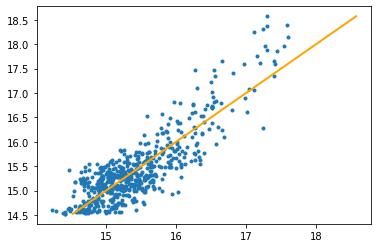

0.015351575281884935


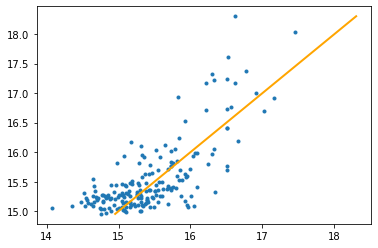

0.032389809687932335


In [89]:
Model_C = train(dataset='C',
                batch_size=3,
                lr=5e-5,
                epochs=512)

eval('C', Model_C)
eval('G', Model_C)

tensor(244.4256, grad_fn=<MseLossBackward0>)
tensor(243.8018, grad_fn=<MseLossBackward0>)
tensor(239.7163, grad_fn=<MseLossBackward0>)
tensor(239.0797, grad_fn=<MseLossBackward0>)
tensor(233.7719, grad_fn=<MseLossBackward0>)
tensor(244.0151, grad_fn=<MseLossBackward0>)
tensor(258.5076, grad_fn=<MseLossBackward0>)
tensor(245.2971, grad_fn=<MseLossBackward0>)
tensor(240.1330, grad_fn=<MseLossBackward0>)
tensor(227.8458, grad_fn=<MseLossBackward0>)
tensor(242.8350, grad_fn=<MseLossBackward0>)
tensor(236.9812, grad_fn=<MseLossBackward0>)
tensor(235.4129, grad_fn=<MseLossBackward0>)
tensor(234.6336, grad_fn=<MseLossBackward0>)
tensor(228.2381, grad_fn=<MseLossBackward0>)
tensor(243.1479, grad_fn=<MseLossBackward0>)
tensor(238.5780, grad_fn=<MseLossBackward0>)
tensor(246.2487, grad_fn=<MseLossBackward0>)
tensor(243.8772, grad_fn=<MseLossBackward0>)
tensor(243.2266, grad_fn=<MseLossBackward0>)
tensor(242.5276, grad_fn=<MseLossBackward0>)
tensor(247.6332, grad_fn=<MseLossBackward0>)
tensor(243

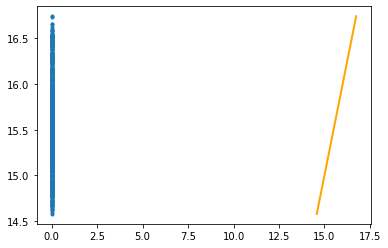

0.5373144967215402


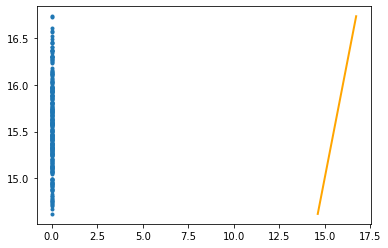

0.9308820452008929


In [90]:
Model_D = train(dataset='D',
                batch_size=8,
                lr=8e-5,
                epochs=1024)

eval('D', Model_D)
eval('H', Model_D)

In [92]:
Model_all = {
    'A': Model_A.state_dict(),
    'B': Model_B.state_dict(),
    'C': Model_C.state_dict()
}
if not os.path.exists('./checkpoints'):
    os.mkdir('./checkpoints')
torch.save(Model_all, './checkpoints/Model_all.pth')


In [120]:
FModel = trainD(dataset='D',
                batch_size=8,
                lr=5e-5,
                epochs=256,
                Model_all='./checkpoints/Model_all.pth')

tensor(70.4278, grad_fn=<MseLossBackward0>)
tensor(73.0972, grad_fn=<MseLossBackward0>)
tensor(64.0273, grad_fn=<MseLossBackward0>)
tensor(43.0123, grad_fn=<MseLossBackward0>)
tensor(54.4747, grad_fn=<MseLossBackward0>)
tensor(79.6589, grad_fn=<MseLossBackward0>)
tensor(70.4232, grad_fn=<MseLossBackward0>)
tensor(58.6343, grad_fn=<MseLossBackward0>)
tensor(67.6109, grad_fn=<MseLossBackward0>)
tensor(72.2826, grad_fn=<MseLossBackward0>)
tensor(45.7399, grad_fn=<MseLossBackward0>)
tensor(84.3843, grad_fn=<MseLossBackward0>)
tensor(75.7516, grad_fn=<MseLossBackward0>)
tensor(70.5221, grad_fn=<MseLossBackward0>)
tensor(76.5121, grad_fn=<MseLossBackward0>)
tensor(70.7363, grad_fn=<MseLossBackward0>)
tensor(76.6760, grad_fn=<MseLossBackward0>)
tensor(61.3709, grad_fn=<MseLossBackward0>)
tensor(58.0020, grad_fn=<MseLossBackward0>)
tensor(81.1223, grad_fn=<MseLossBackward0>)
tensor(80.4268, grad_fn=<MseLossBackward0>)
tensor(69.5869, grad_fn=<MseLossBackward0>)
tensor(84.4355, grad_fn=<MseLoss

KeyboardInterrupt: 

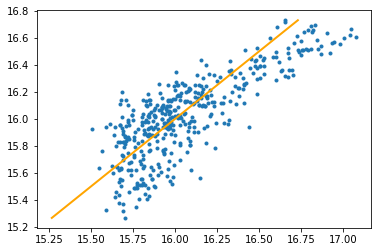

0.010083809704847738
[ 1.38952255e-01 -3.69300842e-02  4.72755432e-01 -1.36212349e-01
  1.10454559e-02  4.22108650e-01 -1.25360489e-01 -1.09252930e-01
 -1.10885620e-01 -8.39614868e-03  2.06089020e-02  3.51889610e-01
  1.12714767e-02  9.88187790e-02 -3.45077515e-01  1.97925568e-02
 -5.78365326e-02 -7.60173798e-02  3.87708664e-01 -1.53601646e-01
 -9.82513428e-02  3.19787979e-01  1.71319962e-01 -2.80818939e-02
  1.65452957e-02  3.35067749e-01 -1.50876999e-01 -7.05118179e-02
  2.39250183e-01 -1.00992203e-01  2.70675659e-01  2.89289474e-01
 -1.29655838e-01  1.06872559e-01  6.27498627e-02 -4.64954376e-02
  1.02163315e-01  8.40244293e-02 -2.62988091e-01  4.81224060e-02
  1.11509323e-01  1.46266937e-01  1.44197464e-01  1.68301582e-01
 -6.63404465e-02  2.75859833e-01 -1.77548409e-01 -2.93548584e-01
 -1.57078743e-01 -1.74715996e-01  1.95999146e-02 -1.53932571e-02
  1.33080482e-01  2.44382858e-01 -7.05013275e-02  3.13112259e-01
  2.28966713e-01  3.28338623e-01  1.45709991e-01  2.68162727e-01
  1.

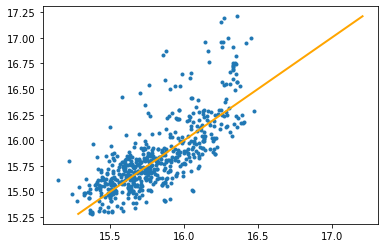

0.009860280487272475
[-7.80820847e-02 -2.50873566e-02 -1.81116104e-01  2.14233398e-02
  1.39371872e-01  1.59845352e-01 -8.55064392e-03 -4.25291061e-02
  1.37230873e-01  1.98097229e-02 -7.97233582e-02  2.77141571e-01
  1.40309334e-01 -2.35618591e-01 -1.40539169e-01  9.43946838e-02
 -6.14959717e-01  1.20166779e-01 -3.27205658e-02 -1.64859772e-01
 -1.14216805e-01  1.94697380e-01  5.61833382e-01 -1.54438019e-02
 -2.03838348e-01 -7.59553909e-02  2.86512375e-01 -6.98686600e-01
 -3.07118416e-01 -6.55528069e-01  8.90579224e-02 -1.98345184e-02
 -6.12468719e-02 -6.45627975e-02 -1.24005318e-01  3.44152451e-01
 -9.08164978e-02  4.59753990e-01 -8.61902237e-02  1.03113174e-01
  7.31086731e-03 -1.57111168e-01 -7.37819672e-02 -2.34423637e-01
 -8.47778320e-02 -1.20505333e-01 -1.46958351e-01  5.33073425e-01
  2.17065811e-01  2.48304367e-01  2.37333298e-01  3.44079018e-01
  2.35958099e-01  1.54452324e-01 -3.25261116e-01  8.80413055e-02
  2.75238037e-01 -6.95196152e-01  8.85381699e-02 -6.66522980e-02
 -3.

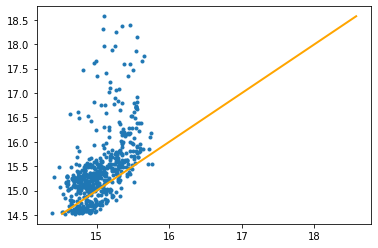

0.03012766440709432
[-4.82478142e-01  1.06430054e-01 -6.11292839e-01  1.23726845e-01
  8.51593018e-02 -4.20484543e-02 -5.39499283e-01  1.59390450e-01
 -8.73575211e-01 -5.85912704e-01 -8.34932327e-02  3.25401306e-01
 -6.52396202e-01 -3.21687698e-01 -3.03016663e-01 -1.00825596e+00
 -1.72328949e-02 -5.18980026e-01 -5.20502090e-01 -3.14254761e-02
  5.79538345e-02  4.63272095e-01 -5.10911942e-02 -5.83400726e-02
 -1.05740261e+00 -4.86373901e-01 -8.61943245e-01  2.59332657e-01
 -6.31567955e-01  3.27437401e-01 -2.28775978e-01  1.86841965e-01
 -6.38637543e-01 -3.61564636e-01 -2.67233944e+00 -7.45676994e-01
 -5.68302155e-01  1.14537239e-01 -2.66535759e-01 -1.18639946e-01
 -3.70448112e-01 -1.12007809e+00  2.90844917e-01 -1.38722420e-01
 -6.48430824e-01 -2.22294807e-01 -3.12390327e-01 -1.30317688e-01
 -2.14388847e-01 -1.47209644e+00 -2.42867470e-01 -1.84283543e+00
 -6.96479797e-01 -3.44931602e-01 -5.63014030e-01 -6.87288284e-01
 -4.78185654e-01 -6.31820679e-01 -4.89306450e-01  1.49379730e-01
 -1.6

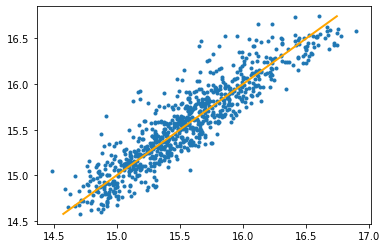

0.006786096663702102
[-1.32374763e-01  1.64140701e-01  5.77630997e-02 -3.50908279e-01
 -2.52882957e-01 -1.30055428e-01 -4.16851044e-02  3.06949615e-02
 -1.98993683e-02  1.30991936e-01 -7.06644058e-02  2.49992371e-01
  1.45866394e-01  8.19072723e-02 -2.51816750e-01 -8.73184204e-03
 -9.57727432e-02 -1.58594131e-01  1.94251060e-01 -5.43327332e-02
  1.90362930e-02  1.87294006e-01 -2.14111328e-01 -1.39797211e-01
 -1.68641090e-01 -4.14924622e-02  3.31344604e-02  4.30192947e-02
  2.66222000e-01  2.09394455e-01  2.77881622e-02  1.91184998e-01
 -6.29529953e-02 -8.21409225e-02  3.31427574e-01 -5.49823761e-01
 -4.87489700e-02 -1.24351501e-01 -3.76072884e-01 -3.04794312e-02
 -6.55848503e-01 -1.66629791e-01  2.68136024e-01  5.66444397e-02
  2.97710419e-01  2.73437500e-02 -1.11708641e-01  1.76067352e-01
  8.80355835e-02 -1.30272865e-01  1.91892624e-01 -5.10578156e-02
  2.51945496e-01  1.70785904e-01  4.62570190e-02  2.17904091e-01
  1.63757324e-01  2.47001648e-02 -1.96843147e-01 -9.92612839e-02
 -3.

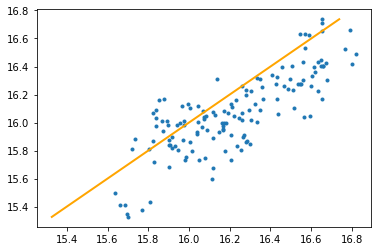

0.019815555760558223
[ 0.09293652  0.37786865  0.10585403 -0.14981747 -0.06633663  0.17277908
  0.19231892  0.21370888  0.02038193  0.10158157 -0.040205   -0.00205708
  0.01788521  0.24292183 -0.25038624  0.25212288  0.37295532  0.45212364
  0.10530281  0.2324171   0.41712284  0.3917017   0.21796036 -0.11757088
 -0.09527206  0.20320892  0.4474249   0.33050537  0.2516079   0.21870708
  0.14142895  0.411026    0.04967499  0.10200691  0.20588493  0.3757801
  0.11915302 -0.09054565 -0.09768295  0.0952282  -0.0839653   0.20565796
 -0.03271484 -0.05500984  0.2780571   0.12972832  0.5223427   0.07886696
 -0.05885696  0.14719963  0.48817062  0.2216978  -0.03819847  0.24956894
  0.2559986   0.0929985   0.2747078   0.03809357 -0.2460537  -0.15235043
  0.31841278  0.07404137  0.38439178  0.2405014   0.518528    0.2607193
 -0.00948524 -0.30424595 -0.13562489  0.1731472   0.27142715  0.20666313
  0.47231197  0.10944843 -0.28719044  0.06770325  0.07532692  0.24547195
  0.05513954  0.06588554  0.3285

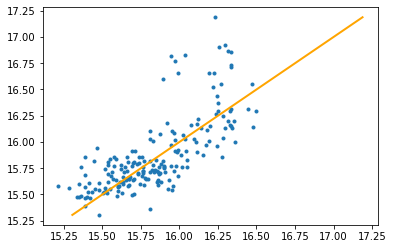

0.017859225471814472
[ 0.36955357  0.14490223 -0.11030483 -0.01211739 -0.7958431  -0.19025803
  0.20575142  0.01297283 -0.0684824   0.06677341 -0.27931404 -0.02986145
  0.08973217  0.04474354 -0.2209425   0.34039497  0.0700531   0.18705559
  0.0445385  -0.1929636   0.06045246  0.27432632  0.20399857 -0.29362583
  0.20246124  0.31252098  0.16595459 -0.19937038  0.27974606  0.18278885
  0.25878525  0.10431671  0.24479103 -0.27312946  0.08210754  0.01716137
 -0.06918335 -0.95825386  0.23799324  0.18427086 -0.03249741 -0.278677
 -0.04644871  0.13807964  0.12009335 -0.8790865  -0.8046036  -0.42933083
 -0.01267338  0.12717247  0.10910988 -0.46838188 -0.11908436 -0.12131596
  0.03647804  0.04484177  0.03717041  0.13077164  0.2169733   0.13991642
 -0.19105339 -0.09339714 -0.20697689 -0.0042429   0.17594528  0.10977554
  0.11512756 -0.2955227   0.08428288 -0.15510559  0.25822926 -0.08028507
  0.07583809 -0.7043848  -0.0876112  -0.25696564  0.03840637  0.02087402
 -0.15088272  0.2005024   0.2891

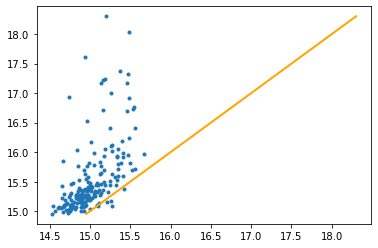

0.052762175599733986
[-1.4347057   0.05947781 -0.14356804 -0.29553986 -0.8456669  -0.42775536
 -0.3867731  -0.03516006 -1.5620775  -0.24580956 -0.22520638 -0.3890438
 -0.35428905 -0.38617802 -0.40730858 -0.3335495  -0.16899967 -0.21047497
 -0.7307272  -0.09118938 -0.52954006 -1.2367926  -0.1580038  -0.26856136
 -0.41386223 -0.23917866 -2.5536604  -0.2529049  -0.17593288 -0.24403667
 -0.24971008 -0.50688744  0.09666538 -0.01488495 -1.1526299  -0.33584118
 -0.3631363  -0.25930882 -0.2814598  -0.3499012  -0.34564972 -0.73737335
 -1.1842241  -0.26285648 -0.35472298 -0.41039658 -1.5493956  -0.40566158
 -0.58905125 -0.23731804 -0.49045086 -0.29649162 -0.70589066 -0.16056728
 -0.51984787 -0.9165001  -0.26960373 -0.87830925 -0.02584553 -0.32676888
 -0.43507957 -0.32824612 -0.21007824 -0.20237827 -0.0692606  -0.46713066
 -0.40393448 -0.5410309  -0.4805565  -0.3232851  -0.7914686  -0.2232542
 -0.6950388  -0.29892826 -0.6858692  -0.701766   -0.9346447  -0.25041676
 -0.7633362  -0.32519436 -0.4268

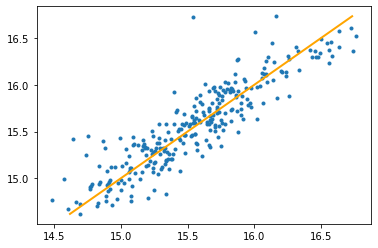

0.01264175432068961
[ 0.04428673  0.1197691   0.13040543 -0.02503967 -0.07872772 -0.01732922
 -0.10862541  0.18487358  0.1910963  -0.10870934  0.28712368 -0.27280903
  0.03034687 -0.16187477  0.02207375  0.27724648 -0.53799057 -0.03098869
 -0.06770992  0.14720154 -0.19050789 -0.03340435 -0.2395525   0.10786152
  0.20787334 -0.18053722  0.09401894 -0.09273148 -0.18694782  0.13590908
  0.08237743 -0.06390762 -0.11756229 -0.03427315  0.00541973  0.01486683
 -0.30705643 -0.08485889 -0.00832367 -0.20110703  0.05468845  0.37289238
  0.12373734 -0.17098808 -0.05939293 -0.2687645  -0.02894306  0.12028885
  0.03200912  0.16600513 -0.78205967 -0.12268257  0.08479691 -0.19027424
  0.33324242 -0.15903854 -0.15446377  0.04287052 -0.22966003 -0.06279945
 -0.5098276   0.01756001  0.19855309  0.14799881 -0.18635082 -0.13588428
  0.20330715 -0.15121365 -0.08267593  0.16901207 -0.11766434 -0.55293655
  0.1845007   0.04823399  0.07699585 -0.09900665 -0.04134846 -0.08200455
  0.32278824 -0.13871765 -0.098

In [119]:
evalD(dataset='A', FModel=FModel)
evalD(dataset='B', FModel=FModel)
evalD(dataset='C', FModel=FModel)
evalD(dataset='D', FModel=FModel)
evalD(dataset='E', FModel=FModel)
evalD(dataset='F', FModel=FModel)
evalD(dataset='G', FModel=FModel)
evalD(dataset='H', FModel=FModel)

In [77]:
def R_curve(dataset, Model_all, FModel):
    set = SeqData(dataset=dataset)
    iter = DataLoader(
        dataset=set,
        batch_size=set.__len__(),
        shuffle=True,
    )
    model_all = torch.load(Model_all)
    A = SeqModel()
    B = SeqModel()
    C = SeqModel()
    A.load_state_dict(model_all['A'])
    B.load_state_dict(model_all['B'])
    C.load_state_dict(model_all['C'])
    A.eval()
    B.eval()
    C.eval()
    for seq, CP, F, BN, label in iter:
        with torch.no_grad():
            A, _ = A(seq)
            B, _ = B(seq)
            C, _ = C(seq)
            P =  FModel(seq, CP)
            break
    _, id = torch.sort(label, dim=0)
    id = id.flatten()
    label = label[id,:]
    A = A[id,:]
    B = B[id,:]
    C = C[id,:]
    P = P[id,:]
    
    plt.plot(A, label='0', alpha=0.5)
    plt.plot(B, label='1', alpha=0.5)
    plt.plot(C, label='3.5', alpha=0.5)
    plt.plot(label)
    # plt.plot(P, color = 'gray', alpha=0.5)
    plt.legend()
    plt.show()


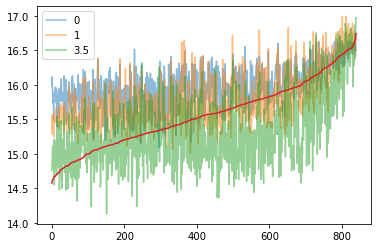

In [78]:
R_curve(dataset='D', 
        Model_all='./checkpoints/Model_all.pth',
        FModel=FModel)